# Power Spectra

## Spherical Harmonic Transformations

In [1]:
import healpy as hp
import pylab as pl
import numpy as np
import camb

%matplotlib inline

In the previous notebook we simulated T, Q and U maps from input TT, TE, EE and BB theory power spectra. Let's repeat it here, simulating 20 maps below.

In [2]:
nside=256
lmax=3*nside-1

H0=67.4
ombh2=0.022383
omch2=0.12011
As=1e-10*np.exp(3.0448)
ns=0.96605
tau=0.0543

pars = camb.set_params(H0=H0, ombh2=ombh2, omch2=omch2, As=As, ns=ns, tau=tau)

pars.WantTensors=True
pars.set_for_lmax(lmax, lens_potential_accuracy=1)

data=camb.get_results(pars)
cells=data.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True)

sim_maps=np.zeros((20,3,hp.nside2npix(nside)))

for i in range(len(sim_maps)):
    sim_maps[i]=hp.synfast(cells['total'].T,nside,new=True)

In this notebook we will infer a power spectrum from these maps. As a first step we have to decompose the maps into harmonic amplitudes by applying the inverse spherical harmonic transformation on the map. With `healpy` this is one line of code.

In [87]:
alm=hp.map2alm(sim_maps[0]) # Apply this one the first realization of T, Q and U maps, i.e. the input is a list of 3 maps

The output of this function, `alm`, is a list of length 3, corresponding to the harmonic coefficients of T, E and B modes, respectively.

## Power Spectra

We can construct an unbiased estimator of power spectra as
$$\hat{C}_\ell = \frac{1}{2\ell+1} \sum_{m=-\ell}^{\ell} a^\dagger_{\ell m} a_{\ell m} . $$
<div class="alert alert-block alert-info">
<b>Exercise:</b> Show that the estimator is unbiased, i.e. for an infinite number of Universes, repeating the power spectrum measurement in each of them, we find $$\lim_{N\rightarrow\infty} \frac{1}{N} \sum_i^N \hat{C}^i_\ell =  C_\ell .$$
</div>

We can construct this estimator by making - like before - the dependence on $\ell$ and $m$ of the harmonic coefficients $a_{\ell m}$ explicit

In [4]:
l,m=hp.Alm.getlm(lmax,np.arange(len(alm[0,:])))

alm_cube=np.zeros((3,lmax+1,2*lmax+1),dtype=complex)
alm_cube[:,l,m]=alm

and keeping in mind that the `alm` vector only stores values for $m\geq 0$ so that we need to make use of the symmetry relation $a_{\ell -m}=(-1)^m a^\dagger_{\ell m}$

In [5]:
l=np.arange(lmax+1)

clm=np.conj(alm_cube)*alm_cube
cl=1/(2*l+1) * (np.sum(clm,axis=-1)+np.sum(clm[:,:,1:],axis=-1))

But, fortunately, there exists a function in `healpy` that does all that for us in one line of code, either using `alm` or maps directly as inputs:

In [89]:
# cl=hp.alm2cl(alm)

cl=hp.anafast(sim_maps[0],lmax=lmax)

We can now plot the estimated spectrum of our first realization of simulated maps and compare it to the input power spectrum calculated with CAMB.

Text(0, 0.5, '$D_{\\ell}^{BB}$ $[\\mu K^2]$')

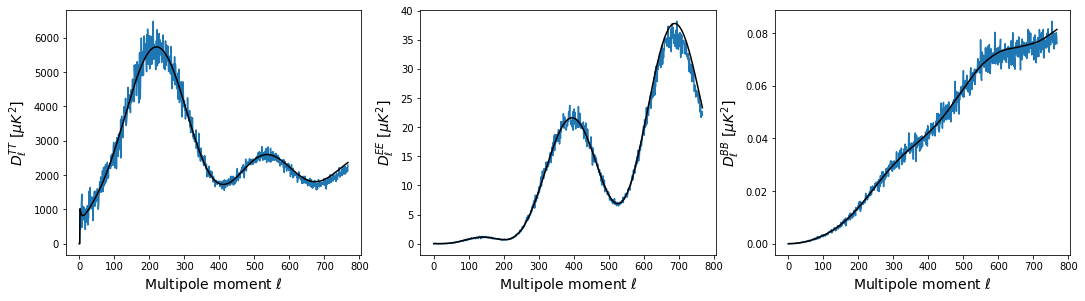

In [90]:
pl.figure(figsize=(18,4.5))

ax=pl.subplot(1,3,1)
pl.plot(l,l*(l+1)/2/np.pi*cl[0])
pl.plot(l,l*(l+1)/2/np.pi*cells['total'][:lmax+1,0],c='k')

ax.set_xlabel('Multipole moment $\ell$',fontsize=14)
ax.set_ylabel('$D_{\ell}^{TT}$ $[\mu K^2]$',fontsize=14)


ax=pl.subplot(1,3,2)
pl.plot(l,l*(l+1)/2/np.pi*cl[1])
pl.plot(l,l*(l+1)/2/np.pi*cells['total'][:lmax+1,1],c='k')

ax.set_xlabel('Multipole moment $\ell$',fontsize=14)
ax.set_ylabel('$D_{\ell}^{EE}$ $[\mu K^2]$',fontsize=14)


ax=pl.subplot(1,3,3)
pl.plot(l,l*(l+1)/2/np.pi*cl[2])
pl.plot(l,l*(l+1)/2/np.pi*cells['total'][:lmax+1,2],c='k')

ax.set_xlabel('Multipole moment $\ell$',fontsize=14)
ax.set_ylabel('$D_{\ell}^{BB}$ $[\mu K^2]$',fontsize=14)

As you can see the simulated spectrum coincides with the theory spectra up to a scatter that is called "cosmic variance". It arises due to the fact that per $\ell$-mode only a limited number of of harmonic coefficients $a_{\ell m}$ exit, putting a fundamental limit to how precisely we can measure the power spectrum $C_\ell$. Only access to a different statistical realization of our observable Universe, e.g. by travelling to a parallel Universe, would give us acces to more modes. On a  computer this is possible to verify. Let's compute spectra for each of our simulated map realizations.

In [92]:
cl=np.array([hp.anafast(m,lmax=lmax) for m in sim_maps])

Next plot them and compute the mean and standard deviation per $\ell$ mode. Feel free to change the value for `field`, i.e. the value 0, 1 and 2 correspond to TT, EE and BB power spectra, respectively.

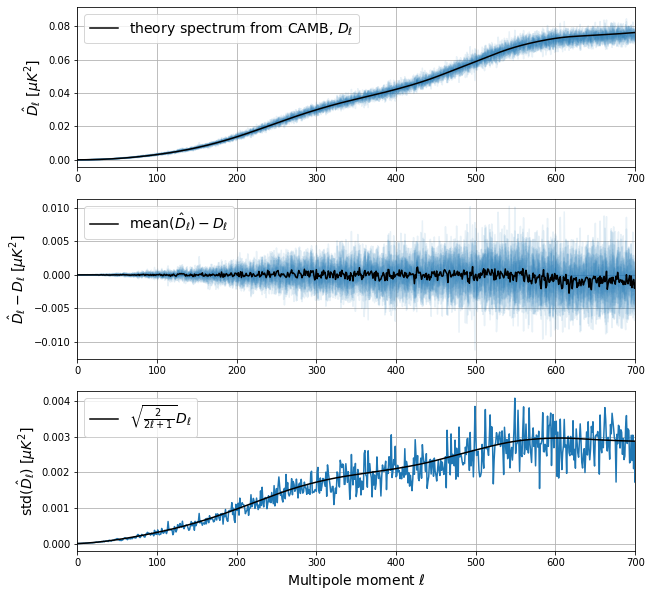

In [93]:
pl.figure(figsize=(10,10))

field=2

ax=pl.subplot(3,1,1)

for c in cl:
    ax.plot(l,l*(l+1)/2/np.pi*c[field,:],c='C0',alpha=.1)
ax.plot(l,l*(l+1)/2/np.pi*cells['total'][:lmax+1,field],c='k',label='theory spectrum from CAMB, $D_{\ell}$')

ax.set_ylabel('$\hat{D}_{\ell}$ $[\mu K^2]$',fontsize=14)
ax.grid()
ax.set_xlim(0,700)
ax.legend(fontsize=14)


ax=pl.subplot(3,1,2)

for c in cl:
    ax.plot(l,l*(l+1)/2/np.pi*(c[field,:]-cells['total'][:lmax+1,field]),c='C0',alpha=.1)
ax.plot(l,l*(l+1)/2/np.pi*(np.mean(cl[:,field,:],axis=0)-cells['total'][:lmax+1,field]),c='k',label='mean$(\hat{D}_{\ell})-D_{\ell}$')

ax.set_ylabel('$\hat{D}_{\ell}-D_{\ell}$ $[\mu K^2]$',fontsize=14)
ax.grid()
ax.set_xlim(0,700)
ax.legend(fontsize=14)


ax=pl.subplot(3,1,3)

ax.plot(l,l*(l+1)/2/np.pi*(np.std(cl[:,field,:],axis=0)),c='C0')
ax.plot(l,l*(l+1)/2/np.pi*np.sqrt(2/(2*l+1))*cells['total'][:lmax+1,field],c='k',label=r'$\sqrt{\frac{2}{2\ell+1}}D_{\ell}$')


ax.set_xlabel('Multipole moment $\ell$',fontsize=14)
ax.set_ylabel('std$(\hat{D}_{\ell})$ $[\mu K^2]$',fontsize=14)
ax.grid()
ax.set_xlim(0,700)
ax.legend(fontsize=14)

<div class="alert alert-block alert-info">
<b>Exercise:</b> What does the bottom panel of the previous plot mean?
</div>

## Masking the Sky Maps

In real life our experiments that we operate from the ground cannot access the full sky. BICEP/Keck telescopes for example are observing a relatively small patch of the sky of about 1% in size. Below we'll load the observing mask of the BICEP2 experiment and plot it on a full sky, Mollweide projection.

In [10]:
mask=hp.read_map('data/bk14_mask_cel_n0512.fits')
mask=np.nan_to_num(mask)
mask=hp.ud_grade(mask,nside)

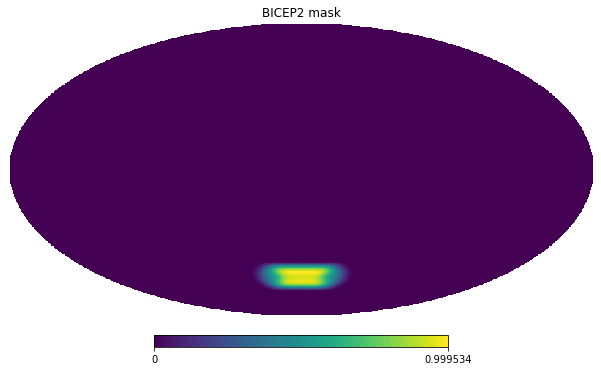

In [11]:
hp.mollview(mask,title='BICEP2 mask')

In [12]:
print('the observed sky fraction is %.1f%%'%(np.mean(mask)*100))

the observed sky fraction is 0.9%


You can see that most of the mask is filled with zeros up to a small region close to the southern celestial pole. The mask is normalized to one and the larger the numerical value in a pixel the more frequent this pixel was observed by BICEP2. Due to the observing startegy of BICEP2 there is a relatively well observed region in the center of the patch, which gradually goes to non-observed pixels towards the edge of the patch.

We can now repeat the power spectrum estimation, multiplying our full-sky maps with this mask.

In [13]:
cl_masked=np.array([hp.anafast(m*mask,lmax=lmax) for m in sim_maps])

Again, we can plot spectra. Note the new variable `scalefactor` that multiplies each spectrum. This factor is chosen assuming  that our signal is the same in and outside of the applied mask. Given that applying the mask to our full sky maps reduces the number of modes with a factor `mean(mask**2)`, we have to divide each spectrum by this factor. We notice that the mean of simulated spectra coincides well with the theory spectrum for the cases TT (`field=0`) and EE (`field=1`), but for BB (`field=2`) we see a large discrepancy, a large bias. Looking closer we can see that the peaks in this bias coincide with the location of peaks in the EE spectrum. This is due to the fact that this bias is caused by so-called E-to-B leakage, a majore problem in the analysis of CMB B-modes.

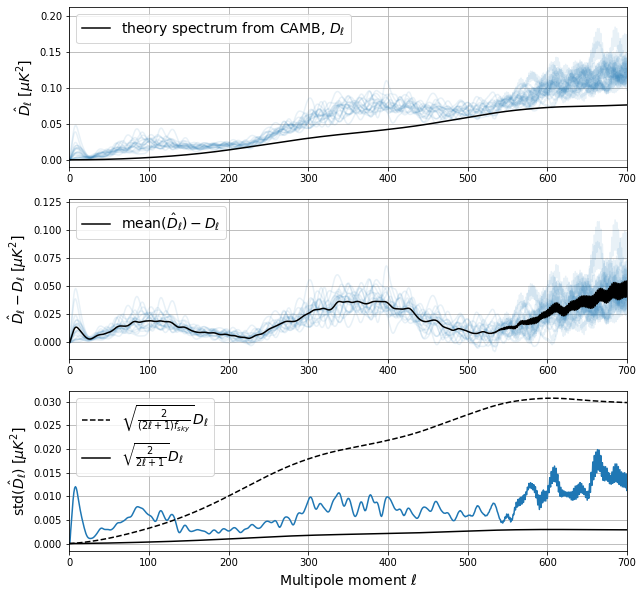

In [95]:
pl.figure(figsize=(10,10))

field=2
scalefactor=1./np.mean(mask**2)

ax=pl.subplot(3,1,1)

for c in cl_masked:
    ax.plot(l,l*(l+1)/2/np.pi*c[field,:]*scalefactor,c='C0',alpha=.1)
ax.plot(l,l*(l+1)/2/np.pi*cells['total'][:lmax+1,field],c='k',label='theory spectrum from CAMB, $D_{\ell}$')

ax.set_ylabel('$\hat{D}_{\ell}$ $[\mu K^2]$',fontsize=14)
ax.grid()
ax.set_xlim(0,700)
ax.legend(fontsize=14)


ax=pl.subplot(3,1,2)

for c in cl_masked:
    ax.plot(l,l*(l+1)/2/np.pi*(c[field,:]*scalefactor-cells['total'][:lmax+1,field]),c='C0',alpha=.1)
ax.plot(l,l*(l+1)/2/np.pi*(np.mean(cl_masked[:,field,:]*scalefactor,axis=0)-cells['total'][:lmax+1,field]),c='k',label='mean$(\hat{D}_{\ell})-D_{\ell}$')

ax.set_ylabel('$\hat{D}_{\ell}-D_{\ell}$ $[\mu K^2]$',fontsize=14)
ax.grid()
ax.set_xlim(0,700)
ax.legend(fontsize=14)


ax=pl.subplot(3,1,3)

ax.plot(l,l*(l+1)/2/np.pi*np.std(cl_masked[:,field,:]*scalefactor,axis=0),c='C0')
ax.plot(l,l*(l+1)/2/np.pi*np.sqrt(2./(2.*l+1)/np.mean(mask))*cells['total'][:lmax+1,field],c='k',label=r'$\sqrt{\frac{2}{(2\ell+1)f_{sky}}}D_{\ell}$',ls='dashed')
ax.plot(l,l*(l+1)/2/np.pi*np.sqrt(2./(2.*l+1))*cells['total'][:lmax+1,field],c='k',label=r'$\sqrt{\frac{2}{2\ell+1}}D_{\ell}$')


ax.set_xlabel('Multipole moment $\ell$',fontsize=14)
ax.set_ylabel('std$(\hat{D}_{\ell})$ $[\mu K^2]$',fontsize=14)
ax.grid()
ax.set_xlim(0,700)
ax.legend(fontsize=14)

The main reason the plots of masked spectra look so horrible is so-called modecoupling, i.e. the fact that due to masking the individual $\ell$-modes are not anymore independent (remember, we simulated them independently in the previous notebook) and cannot be estimated independently anymore. We can visualize that by calculating the correlation matrix of these masked spectra. Below we compare the correlations of unmasked and masked spectra. Note the appearance of the braod band of correlation around the diagonal for the case of masked spectra.

/home/users/dobeck/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/users/dobeck/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Text(0.5, 1.0, 'Multipole-to-multipole correlations: masked sky')

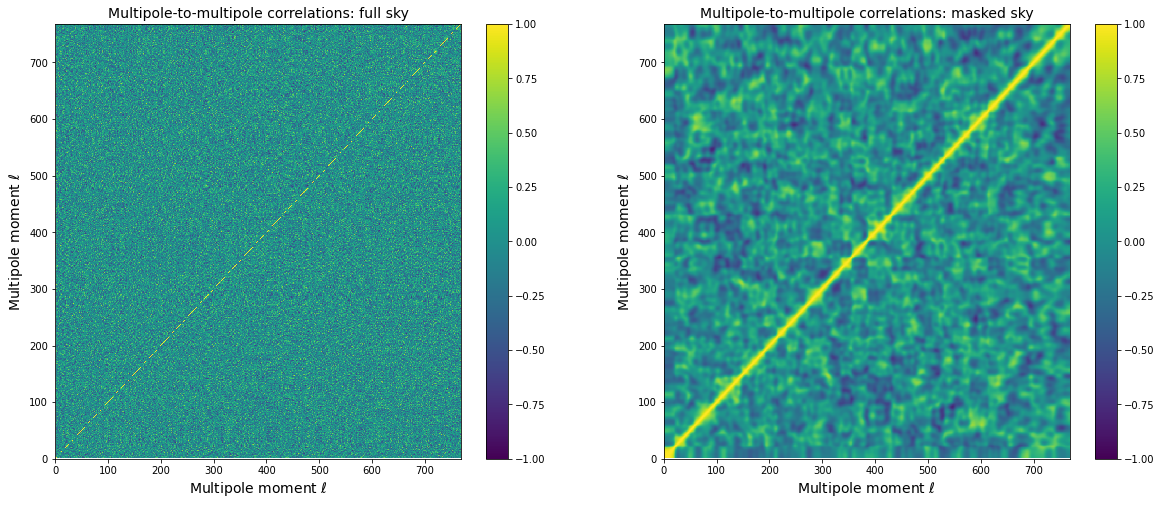

In [96]:
field=1

pl.figure(figsize=(20,8))


ax=pl.subplot(1,2,1)

cov=np.corrcoef(cl[:,field,:]*scalefactor,rowvar=False)

pl.pcolormesh(cov,vmin=-1,vmax=1)
pl.colorbar()

pl.xlabel('Multipole moment $\ell$',fontsize=14)
pl.ylabel('Multipole moment $\ell$',fontsize=14)

pl.title('Multipole-to-multipole correlations: full sky',fontsize=14)


ax=pl.subplot(1,2,2)

cov=np.corrcoef(cl_masked[:,field,:]*scalefactor,rowvar=False)

pl.pcolormesh(cov,vmin=-1,vmax=1)
pl.colorbar()

pl.xlabel('Multipole moment $\ell$',fontsize=14)
pl.ylabel('Multipole moment $\ell$',fontsize=14)

pl.title('Multipole-to-multipole correlations: masked sky',fontsize=14)

## Binning

One way to aleviate this modecoupling to some extent is to bin the spectra, i.e. to just average a predefined number of multipoles $\ell$ into one bin $b$. Bewlo we define the bin edges (`bins`), resulting bin centers (`b`) and a function that performs the binning.

In [97]:
bins=np.arange(20,700,35)
b=.5*(bins[1:]+bins[:-1])

def bin_spectra(cl):
    cb=np.zeros((*np.shape(cl)[:-1],len(bins)-1)) # The output array should have the same shape as the input spectrum array, except for the last dimension
    for i in range(len(bins)-1):
        cb[...,i]=np.mean(cl[...,bins[i]:bins[i+1]],axis=-1)
    return cb

Now we can bin our masked spectra as well as the theory spectra.

In [17]:
cl_binned=bin_spectra(l*(l+1)/2/np.pi*cl_masked)
cbt=bin_spectra(l*(l+1)/2/np.pi*cells['total'][:lmax+1,:].T)

Now we can plot again. Note again we change the equation to compute the black line in the bottom panel, to compute the standard deviation from the theory input spectrum. Again one can arrive at it by counting the number of modes that go into the measurement of the power spectrum in each given bin ($\Delta b$ is the size of each bin). We see that this standard deviation from theory now coincides much better with the standard deviation measured from simulations now that we have binned the spectra.

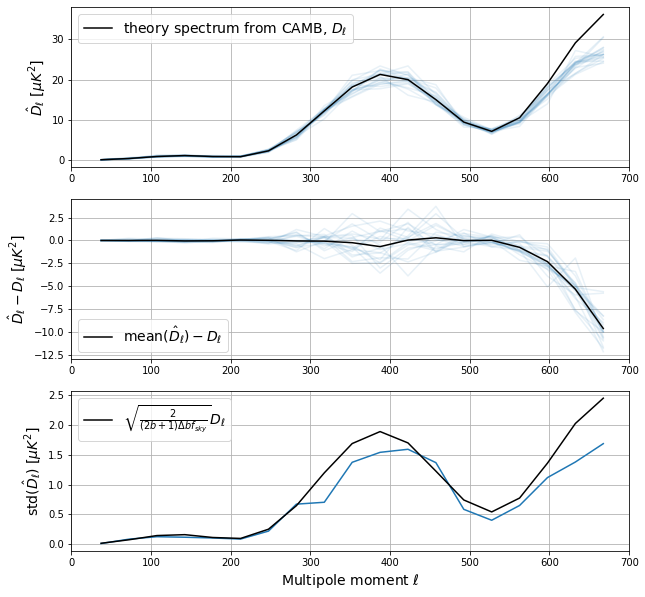

In [98]:
pl.figure(figsize=(10,10))

field=1
scalefactor=1./np.mean(mask**2)

ax=pl.subplot(3,1,1)

for c in cl_binned:
    ax.plot(b,c[field,:]*scalefactor,c='C0',alpha=.1)
ax.plot(b,cbt[field],c='k',label='theory spectrum from CAMB, $D_{\ell}$')

ax.set_ylabel('$\hat{D}_{\ell}$ $[\mu K^2]$',fontsize=14)
ax.grid()
ax.set_xlim(0,700)
ax.legend(fontsize=14)


ax=pl.subplot(3,1,2)

for c in cl_binned:
    ax.plot(b,(c[field,:]*scalefactor-cbt[field]),c='C0',alpha=.1)
ax.plot(b,(np.mean(cl_binned[:,field,:]*scalefactor,axis=0)-cbt[field]),c='k',label='mean$(\hat{D}_{\ell})-D_{\ell}$')

ax.set_ylabel('$\hat{D}_{\ell}-D_{\ell}$ $[\mu K^2]$',fontsize=14)
ax.grid()
ax.set_xlim(0,700)
ax.legend(fontsize=14)


ax=pl.subplot(3,1,3)

ax.plot(b,np.std(cl_binned[:,field,:]*scalefactor,axis=0),c='C0')
ax.plot(b,np.sqrt(2./(2.*b+1)/35/np.mean(mask))*cbt[field],c='k',label=r'$\sqrt{\frac{2}{(2b+1)\Delta b f_{sky}}}D_{\ell}$')


ax.set_xlabel('Multipole moment $\ell$',fontsize=14)
ax.set_ylabel('std$(\hat{D}_{\ell})$ $[\mu K^2]$',fontsize=14)
ax.grid()
ax.set_xlim(0,700)
ax.legend(fontsize=14)

We can verify that the modecoupling (now bin-to-bin coupling) is significantly reduced.
<div class="alert alert-block alert-info">
<b>Exercise:</b> Go back at the beginning and increase the number of simulations. What would you expect happens to the correlation matrices? Compare correlation matrices for different number of simulations.
</div>

Text(0.5, 1.0, 'Bin-to-bin correlations: masked sky')

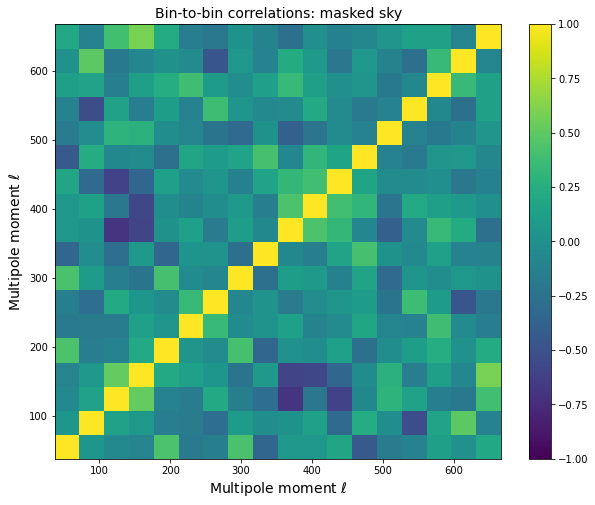

In [45]:
field=1

pl.figure(figsize=(10,8))


cov=np.corrcoef(cl_binned[:,field,:]*scalefactor,rowvar=False)

pl.pcolormesh(b,b,cov,vmin=-1,vmax=1)
pl.colorbar()

pl.xlabel('Multipole moment $\ell$',fontsize=14)
pl.ylabel('Multipole moment $\ell$',fontsize=14)

pl.title('Bin-to-bin correlations: masked sky',fontsize=14)

## Modecoupling

With some assumptions one can compute the modecoupling between $\ell$-modes. You can find more details on how to do that [here](https://arxiv.org/pdf/1809.09603.pdf). Here we use the python module `pur` to compute it. It simply requires the "power spectrum" of the mask. This modecoupling is described by the modecoupling matrix, `mcm`, defined as
$$
\hat{C}^X_\ell = M^{XY}_{\ell\ell^\prime} C^Y_{\ell^\prime},
$$
where $C^Y_\ell$ is the power spectrum on the full sky (averaged over infinite realizations) and $\hat{C}^X_\ell$ is the power spectrum of the masked sky (averaged over many realizations). With that we can approximate the modecoupling we see in our measured masked spectrum.

In [46]:
import pur

In [80]:
mcl=hp.anafast(mask,lmax=lmax)
mcm=pur.compute_mcm(mcl,lmax=lmax)

/home/users/dobeck/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/users/dobeck/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in matmul


Text(0.5, 1.0, 'Multipole-to-multipole correlations: analytic calculation')

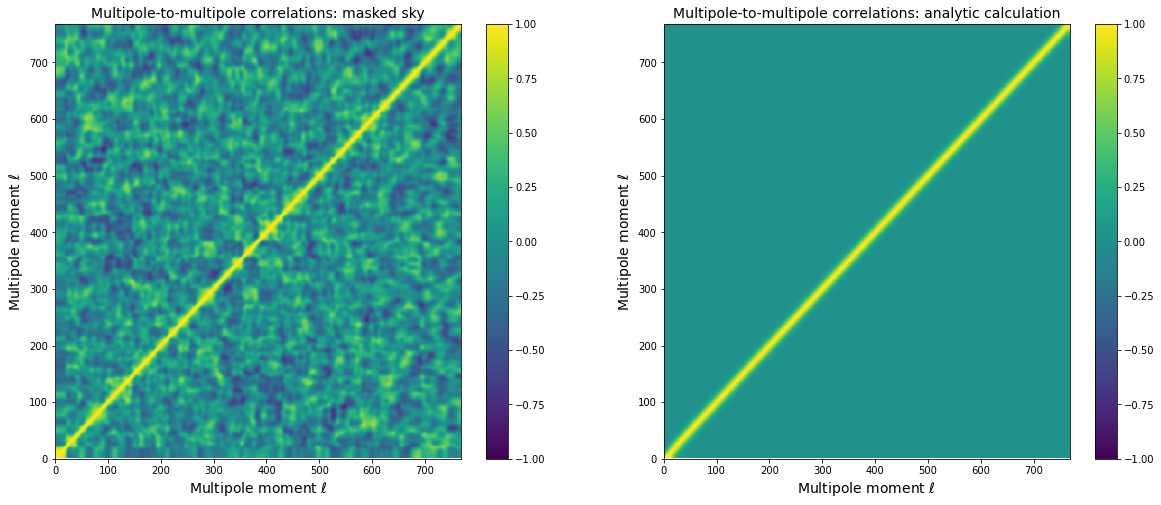

In [102]:
field=1

pl.figure(figsize=(20,8))


ax=pl.subplot(1,2,1)

cov=np.corrcoef(cl_masked[:,field,:]*scalefactor,rowvar=False)

pl.pcolormesh(cov,vmin=-1,vmax=1)
pl.colorbar()

pl.xlabel('Multipole moment $\ell$',fontsize=14)
pl.ylabel('Multipole moment $\ell$',fontsize=14)

pl.title('Multipole-to-multipole correlations: masked sky',fontsize=14)


ax=pl.subplot(1,2,2)

field2spec={0:'TT',1:'EE',2:'BB'}
cov=mcm[field2spec[field]][field2spec[field]]
cov=cov@cov
u=np.diag(1./np.sqrt(np.diag(cov)))

pl.pcolormesh(u@cov@u,vmin=-1,vmax=1)
pl.colorbar()

pl.xlabel('Multipole moment $\ell$',fontsize=14)
pl.ylabel('Multipole moment $\ell$',fontsize=14)

pl.title('Multipole-to-multipole correlations: analytic calculation',fontsize=14)

We can now convolve the theory spectrum with the modecoupling matrix.

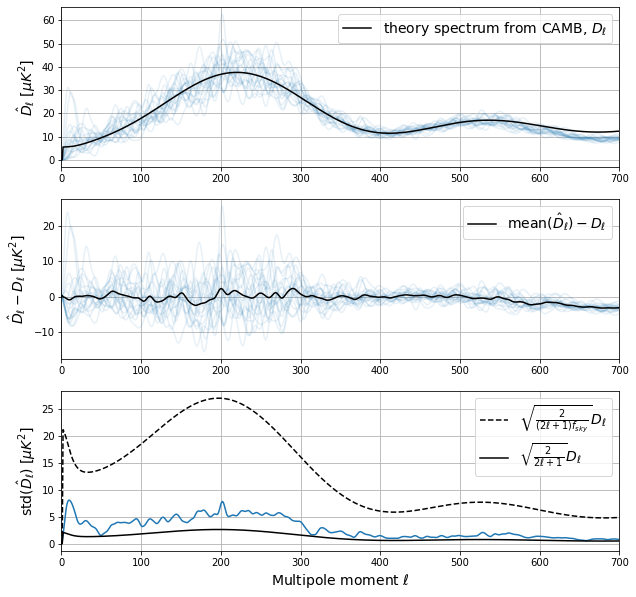

In [86]:
pl.figure(figsize=(10,10))

field=0
scalefactor=1.
MCM=mcm[field2spec[field]][field2spec[field]]

ax=pl.subplot(3,1,1)

for c in cl_masked:
    ax.plot(l,l*(l+1)/2/np.pi*c[field,:]*scalefactor,c='C0',alpha=.1)
ax.plot(l,l*(l+1)/2/np.pi*MCM@cells['total'][:lmax+1,field],c='k',label='theory spectrum from CAMB, $D_{\ell}$')

ax.set_ylabel('$\hat{D}_{\ell}$ $[\mu K^2]$',fontsize=14)
ax.grid()
ax.set_xlim(0,700)
ax.legend(fontsize=14)


ax=pl.subplot(3,1,2)

for c in cl_masked:
    ax.plot(l,l*(l+1)/2/np.pi*(c[field,:]*scalefactor-MCM@cells['total'][:lmax+1,field]),c='C0',alpha=.1)
ax.plot(l,l*(l+1)/2/np.pi*(np.mean(cl_masked[:,field,:]*scalefactor,axis=0)-MCM@cells['total'][:lmax+1,field]),c='k',label='mean$(\hat{D}_{\ell})-D_{\ell}$')

ax.set_ylabel('$\hat{D}_{\ell}-D_{\ell}$ $[\mu K^2]$',fontsize=14)
ax.grid()
ax.set_xlim(0,700)
ax.legend(fontsize=14)


ax=pl.subplot(3,1,3)

ax.plot(l,l*(l+1)/2/np.pi*np.std(cl_masked[:,field,:]*scalefactor,axis=0),c='C0')
ax.plot(l,l*(l+1)/2/np.pi*np.sqrt(2./(2.*l+1)/np.mean(mask))*MCM@cells['total'][:lmax+1,field],c='k',label=r'$\sqrt{\frac{2}{(2\ell+1)f_{sky}}}D_{\ell}$',ls='dashed')
ax.plot(l,l*(l+1)/2/np.pi*np.sqrt(2./(2.*l+1))*MCM@cells['total'][:lmax+1,field],c='k',label=r'$\sqrt{\frac{2}{2\ell+1}}D_{\ell}$')


ax.set_xlabel('Multipole moment $\ell$',fontsize=14)
ax.set_ylabel('std$(\hat{D}_{\ell})$ $[\mu K^2]$',fontsize=14)
ax.grid()
ax.set_xlim(0,700)
ax.legend(fontsize=14)

Alternatively one could try to invert the modecoupling matrix and apply it on the measured, masked spectrum. But ...

In [78]:
invmcm=np.linalg.inv(mcm['EE']['EE'][2:,2:])
print('Conditioning number of the modecoupling matrix: %f'%np.linalg.cond(mcm['EE']['EE'][2:,2:]))

Conditioning number of the modecoupling matrix: 266999763587742.312500


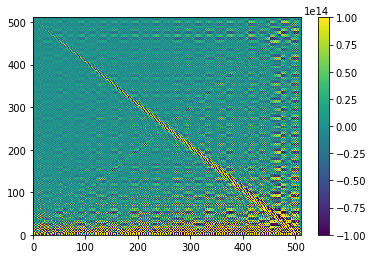

In [75]:
pl.pcolormesh(invmcm,vmin=-1e14,vmax=1e14)
pl.colorbar()

... this matrix is not invertible. Despite `np.linalg.inv` not throwing any error, the conditioning number is very large and the resulting inverse doesn't look very trustworthy.

<div class="alert alert-block alert-info">
<b>Exercise:</b> Construct a binned version of the modecoupling matrix, invert it and apply it to the binned spectra.
</div>

Now that you have a basic understanding of how to estimate a power spectrum, feel free to use publicly available tools to efficiently and reliably estimate power spectra. They also include ways to deal with E-to-B leakage due to sky masking. Examples of available codes are:
- [PSpipe](https://github.com/simonsobs/PSpipe)
- [NaMaster](https://github.com/LSSTDESC/NaMaster)
- [PUR](https://github.com/doicbek/PUR)